# **Associations between aversive learning processes and transdiagnostic psychiatric symptoms revealed by large-scale phenotyping**

---

# Analyses relating behaviour to psychopathology

Here we construct regression models to test associations between behavioural variables derived from out computational models and our questionnaire measures.

# Imports and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale
from bambi import Model
import seaborn as sns
from scipy.stats.distributions import halfcauchy
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
from collections import OrderedDict
import os
import matplotlib
from matplotlib.lines import Line2D
from bambi import Family, Prior
import pymc3 as pm
import dill
import re
import json
import matplotlib.font_manager as font_manager
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2', '#861388', '#171a21', '#a5a5a5']
light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

np.random.seed(123)

# Helper functions #

def construct_equation(predictors, outcome):

    """
    Constructs a regression equation for bambi
    Args:
        predictors: predictor variables, list of strings
        outcome: outcome variable, single string

    Returns:
        Equation of the form y ~ x1 + x2...
    """

    eq_string = '{0} ~ '.format(outcome)

    if isinstance(predictors, dict):
        predictors = predictors.values()

    for n, i in enumerate(predictors):
        if n == 0:
            eq_string += '{0}'.format(i)
        else:
            eq_string += ' + {0}'.format(i)

    return eq_string

# Nicer looking outcome names
outcomes_dict = {'mean_tau_n': 'Threat update\n$\\tau^-$', 'mean_tau_p': 'Safety update\n$\\tau^+$', 
              'mean_uncertainty': 'Mean safety\nuncertainty', 'mean_value': 'Mean safety\nprobability', 'ws': 'Safety-stay', 'ls': 'Danger-switch'}

def make_table_look_nice(df):
    """
    Takes a dataframe of regression results and makes it look nice
    """
    df = df.copy()
    df = df[['mean', 'hpd0.95_lower', 'hpd0.95_upper', 'outcome']]

    df['outcome'] = df['outcome'].replace(outcomes_dict)
    df['Target variable'] = df['outcome'].str.replace('te\n', 'te (')
    df.loc[df['Target variable'].str.contains('update'), 'Target variable'] = df['Target variable'][df['Target variable'].str.contains('update')] + ')'
    df.loc[df['Target variable'].str.contains('Mean'), 'Target variable'] = df['Target variable'][df['Target variable'].str.contains('Mean')].str.replace('\n', ' ')
    df['Estimate (+/- HPDI)'] = df['mean'].round(2).astype(str) + ' (' + df['hpd0.95_lower'].round(2).astype(str) + ', ' + df['hpd0.95_upper'].round(2).astype(str) + ')'
    df['Predictor'] = df.index
    df['Predictor'] = df['Predictor'].str.replace('_', ' ')
    df = df[~((df['outcome'].str.contains('decay')) | (df['outcome'].str.contains('stick')) | (df['outcome'].str.contains('temp')))].reset_index(drop=True)
    df = df[['Target variable', 'Predictor', 'Estimate (+/- HPDI)']]

    return df

def remove_other_vars(df):
    return df[~((df['outcome'].str.contains('decay')) | 
                (df['outcome'].str.contains('stick')) | 
                (df['outcome'].str.contains('temp')))]

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Combine questionnaire and modelling data

Here we get the questionnare data (`qns`), scores on the avoidance test (`avoidance`), and modelling-derived variables such as update parameters and value/uncertainty estimates (`modelling`).

In [2]:
# Read various dataframes
qns = pd.read_csv('../Data/qns_full.csv')
raw_qns = pd.read_csv('../Data/raw_qns.csv')
behaviour = pd.read_csv('../Data/behavioural_measures.csv')
modelling = pd.read_csv('../Data/subject_param_values.csv')
avoidance = pd.read_csv('../Data/raw_data/task/avoidance_test_scores.txt', header=None)
avoidance.columns=['Subject', 'mean_health']
avoidance.Subject = avoidance.Subject.str.replace(' ', '')
avoidance = avoidance.drop_duplicates('Subject', keep='last')

# Merge dataframes
dfs = [qns, modelling, avoidance, raw_qns[['Subject'] + [i for i in raw_qns.columns if i not in qns.columns]], behaviour]
full_df = reduce(lambda left,right: pd.merge(left,right,on='Subject'), dfs)
full_df = full_df[[i for i in full_df.columns if not 'Unnamed' in i]]
full_df = full_df.drop_duplicates('Subject')
print "Number of subjects = {0}".format(len(full_df))

Number of subjects = 400


### Run some checks

Check that:

* We don't have any data with missing or invalid values
* We don't have any negative values in things that shouldn't have negative values (factor scores are already scaled so these may have negative values)
* We don't have duplicate subjects

In [3]:
assert full_df.Subject.value_counts().max() == 1, 'Duplicate subject IDs'
assert np.any(full_df.isnull()) == False, 'NaNs or Infs present in data'
assert np.any(full_df.drop('mean_pe', axis=1).iloc[:, 4:] < 0) == False, 'Values below zero'

## Look at data distributions

Now we'll look at the distributions of our variables to make sure nothing weird is going on.

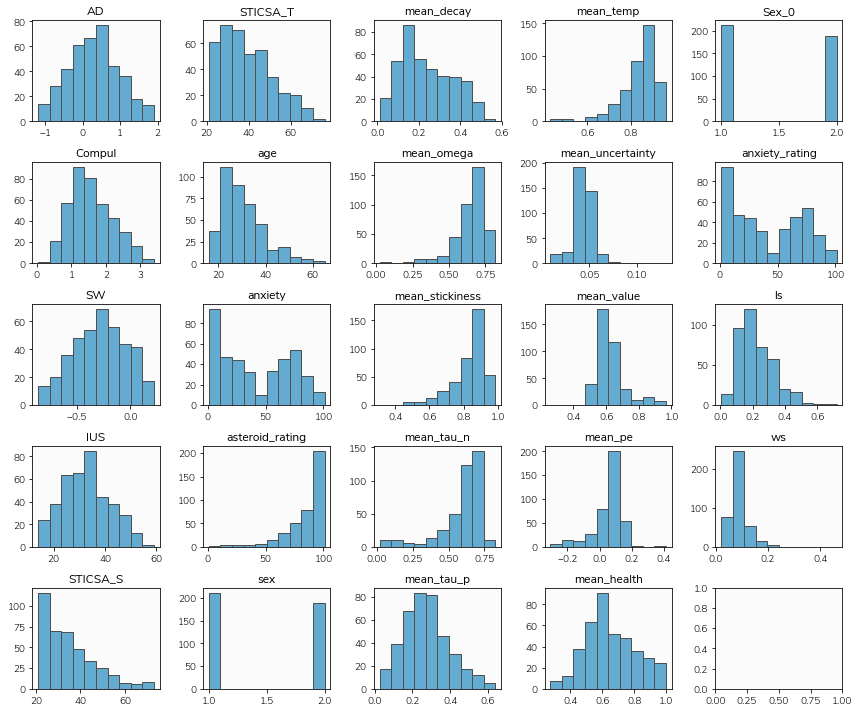

In [4]:
vars = [i for i in full_df.columns if 'Subject' not in i and 'hpd' not in i and 'sd_' not in i and 'mc_error' not in i and '.' not in i]

f, ax = plt.subplots(5, np.ceil(len(vars) / 5.).astype(int), figsize=(12, 10), facecolor='white')

for n, var in enumerate(vars):
    ax[n % 5, n / 5].hist(full_df[var], ec=pal[0], color=light_pal[2])
    ax[n % 5, n / 5].set_title(var)
    
plt.tight_layout()

### Approximate number of subjects meeting clinical cutoff for anxiety

A score of 43 on the STICSA trait measure has been suggested as a good cutoff for detecting probable cases of clinical anxiety disorders (https://www.tandfonline.com/doi/full/10.1080/10615806.2011.631525)

In [5]:
n_above_cutoff = (full_df['STICSA_T'] >= 43).sum()
"Number of subjects scoring at or above the cut-off = {0}, percentage of sample = {1}%".format(n_above_cutoff, n_above_cutoff / float(len(full_df)) * 100)

'Number of subjects scoring at or above the cut-off = 143, percentage of sample = 35.75%'

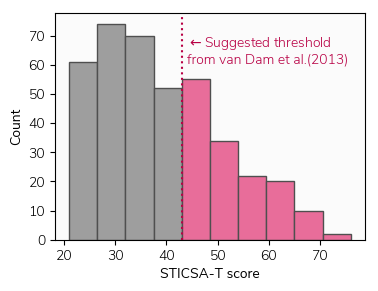

In [6]:
plt.figure(figsize=(4, 3), dpi=100)

N, bins, patches = plt.hist(full_df['STICSA_T'], ec=pal[0], color=light_pal[0])

for i in range(len(bins) - 1):
    if bins[i] >= 43:
        patches[i].set_facecolor(light_pal[1])
        
plt.axvline(43, linestyle=':', color=pal[1])

plt.text(44, 61, r'$\leftarrow$' + 'Suggested threshold\nfrom van Dam et al.(2013)', color=pal[1])

plt.xlabel("STICSA-T score")
plt.ylabel("Count")
plt.savefig('../figures/sticsa_clinical_threshold.svg')

## Subjective anxiety and avoidance

After the task we ask people how anxious it made them feel and how much they wanted to avoid the asteroids.

In [7]:
print("Mean motivation score = {0}, (SD = {1})".format(full_df['asteroid_rating'].mean(), full_df['asteroid_rating'].std()))
print("Mean anxiety score = {0}, (SD = {1})".format(full_df['anxiety'].mean(), full_df['anxiety'].std()))

Mean motivation score = 85.6925, (SD = 18.542991941)
Mean anxiety score = 40.72, (SD = 30.5001187392)


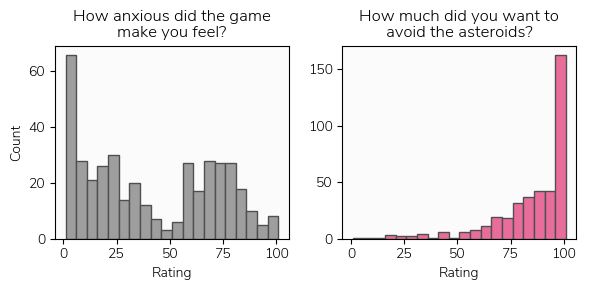

In [8]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100, facecolor='white')

ax[0].hist(full_df['anxiety'], ec=pal[0], bins=20, color=light_pal[0])
ax[0].set_xlabel("Rating", fontweight='light')
ax[0].set_ylabel("Count", fontweight='light')
ax[0].set_title("How anxious did the game\nmake you feel?", fontweight='light')

ax[1].hist(full_df['asteroid_rating'], ec=pal[0], bins=20, color=light_pal[1])
ax[1].set_xlabel("Rating", fontweight='light')
ax[1].set_title("How much did you want to\navoid the asteroids?", fontweight='light');

plt.tight_layout()

plt.savefig('../figures/subjective_ratings.png')
plt.savefig('../figures/subjective_ratings.svg')

### Relationships with state + trait anxiety

There might be some interesting relationships between task-induced anxiety and state/trait anxiety - let's have a look.

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


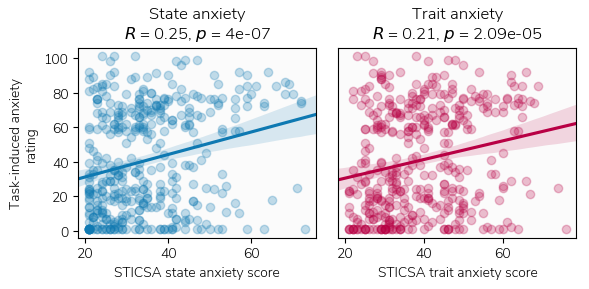

In [9]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100, facecolor='white')

state_r = pearsonr(full_df['STICSA_S'], full_df['anxiety'])
trait_r = pearsonr(full_df['STICSA_T'], full_df['anxiety'])

full_df['STICSA_S']

# full_df['STICSA_S'] += 20
# full_df['STICSA_T'] -= 20

sns.regplot('STICSA_S', 'anxiety', data=full_df, ax=ax[0], color=pal[2], line_kws={'color': pal[2]}, scatter_kws={'alpha': 0.25})
sns.regplot('STICSA_T', 'anxiety', data=full_df, ax=ax[1], color=pal[1], line_kws={'color': pal[1]}, scatter_kws={'alpha': 0.25})

ax[0].set_title("State anxiety\n$R$ = {0}, $p$ = {1}".format(np.round(state_r[0], 2), np.round(state_r[1], 7)), fontweight='light')
ax[1].set_title("Trait anxiety\n$R$ = {0}, $p$ = {1}".format(np.round(trait_r[0], 2), np.round(trait_r[1], 7)), fontweight='light')

ax[0].set_xlabel('STICSA state anxiety score', fontweight='light')
ax[1].set_xlabel('STICSA trait anxiety score', fontweight='light')

ax[0].set_ylabel('Task-induced anxiety\nrating', fontweight='light')
ax[1].set_ylabel('')

ax[1].set_yticks([])
ax[1].set_yticklabels([])

# sns.despine()
plt.tight_layout()

# Save figures
plt.savefig('../figures/subjective_ratings_STICSA.png')
plt.savefig('../figures/subjective_ratings_STICSA.svg')

## Relationship between model-free and model-derived measures of learning

To verify that parameter values from our (quite complex) model map on to simple behavioural patterns that they should be related to, we can calculate correlations between the two. Here we take the update rates for danger and safety and look at how they relate to how much subjects shift their position in response to safety and danger on average. If our model is behaving sensibly, they should be related - people who update more in response to danger should shift their position more after encountering danger. However it should be noted that this relationship shouldn't be perfect, as there are many other factors that affect how much people shift aside from their updates.

In [10]:
correlations = full_df[['ls', 'ws', 'mean_tau_p', 'mean_tau_n']].corr().round(2)
correlations

,ls,ws,mean_tau_p,mean_tau_n
ls,1.00,0.31,-0.31,0.25
ws,0.31,1.00,0.12,-0.24
mean_tau_p,-0.31,0.12,1.00,-0.49
mean_tau_n,0.25,-0.24,-0.49,1.00


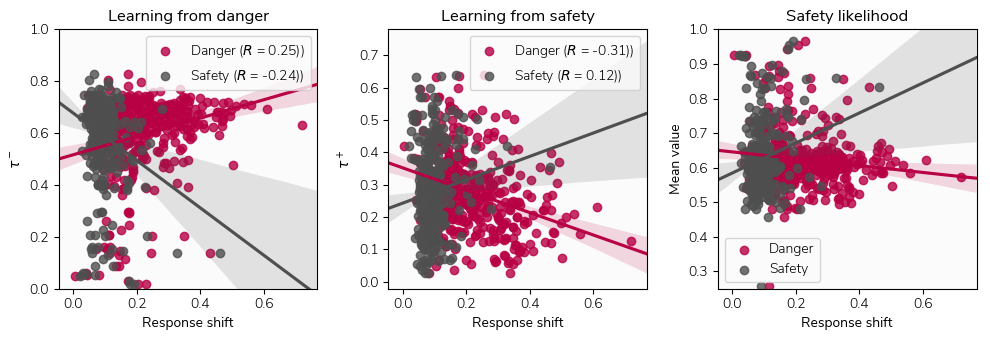

In [11]:
f, ax = plt.subplots(1, 3, figsize=(10, 3.5), dpi=100)

# Threat learning
sns.regplot(full_df['ls'], full_df['mean_tau_n'], ax=ax[0], color=pal[1], label=r'Danger ($R$ = {}))'.format(correlations.loc['ls', 'mean_tau_n']))
sns.regplot(full_df['ws'], full_df['mean_tau_n'], ax=ax[0], color=pal[0], label=r'Safety ($R$ = {}))'.format(correlations.loc['ws', 'mean_tau_n']))
ax[0].legend(loc='upper right')
ax[0].set_xlabel("Response shift")
ax[0].set_ylabel("$\\tau^-$")
ax[0].set_title("Learning from danger")
ax[0].set_ylim(0, 1)

sns.regplot(full_df['ls'], full_df['mean_tau_p'], ax=ax[1], color=pal[1], label=r'Danger ($R$ = {}))'.format(correlations.loc['ls', 'mean_tau_p']))
sns.regplot(full_df['ws'], full_df['mean_tau_p'], ax=ax[1], color=pal[0], label=r'Safety ($R$ = {}))'.format(correlations.loc['ws', 'mean_tau_p']))
ax[1].legend()
ax[1].set_xlabel("Response shift")
ax[1].set_ylabel("$\\tau^+$")
ax[1].set_title("Learning from safety")

sns.regplot(full_df['ls'], full_df['mean_value'], ax=ax[2], color=pal[1], label='Danger')
sns.regplot(full_df['ws'], full_df['mean_value'], ax=ax[2], color=pal[0], label='Safety')
ax[2].legend()
ax[2].set_xlabel("Response shift")
ax[2].set_ylabel("Mean value")
ax[2].set_title("Safety likelihood")
ax[2].set_ylim(0.25, 1)

plt.tight_layout()
plt.savefig('../figures/learning_behavioural_shifts.svg')

## Regressions

Scale data before entering into regressions to between zero and 1 (this means we have equivalent scales across all variables).

In [12]:
unscaled = ['Subject'] # We don't want the subject ID column to be affected
full_df[[c for c in full_df.columns if c not in unscaled]] = scale(full_df[[c for c in full_df.columns if c not in unscaled]])

full_df.head()

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,AD,Compul,SW,Subject,IUS,STICSA_S,STICSA_T,age,anxiety,asteroid_rating,...,zung.11,zung.12,zung.13,zung.14,zung.16,zung.17,zung.18,zung.20,ls,ws
0,0.383095,-0.200489,0.203683,sub0000,-0.598109,0.872744,0.751514,2.472533,0.994026,0.556567,...,-0.483696,-0.351056,0.058899,0.578450,0.439087,0.479953,0.389434,0.751061,1.345027,0.232050
1,0.192809,0.402226,0.780020,sub0001,-0.598109,0.787432,0.751514,-1.009525,1.913205,0.124596,...,0.539999,0.644847,-1.011998,1.567253,1.510031,1.517690,-0.584151,-0.281325,-0.452335,0.491875
2,-0.568870,1.884240,0.245966,sub0002,1.246399,2.067115,1.840968,1.166762,1.190993,-1.333303,...,-0.483696,-0.351056,1.129797,-1.399157,-0.631857,-0.557783,-0.584151,-0.281325,0.353246,-0.024109
3,-0.186693,-0.955210,-1.116359,sub0003,-1.357612,-1.174749,-0.254136,2.037276,-1.303921,-0.145385,...,-0.483696,-0.351056,-1.011998,-0.410353,-0.631857,0.479953,-0.584151,0.751061,-0.628151,-0.184117
4,-0.146276,-0.314646,0.865226,sub0004,0.920897,-0.151003,-0.421745,0.405061,1.158165,0.610563,...,-0.483696,-1.346959,0.058899,-0.410353,0.439087,0.479953,0.389434,0.751061,0.739391,-0.337627


Check that the data is scaled properly

In [13]:
assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]].mean().round() != 0) == False, 'Scaling failed, mean != 0'
assert np.any(full_df[[c for c in full_df.columns if c not in unscaled]].std().round() != 1) == False, 'Scaling failed, sd != 1'
assert np.any(full_df.isnull()) == False, 'Missing data'

full_df.to_csv('../Data/full_df.csv')

## Correlations between variables

This just demonstrates relationships between all our variables.

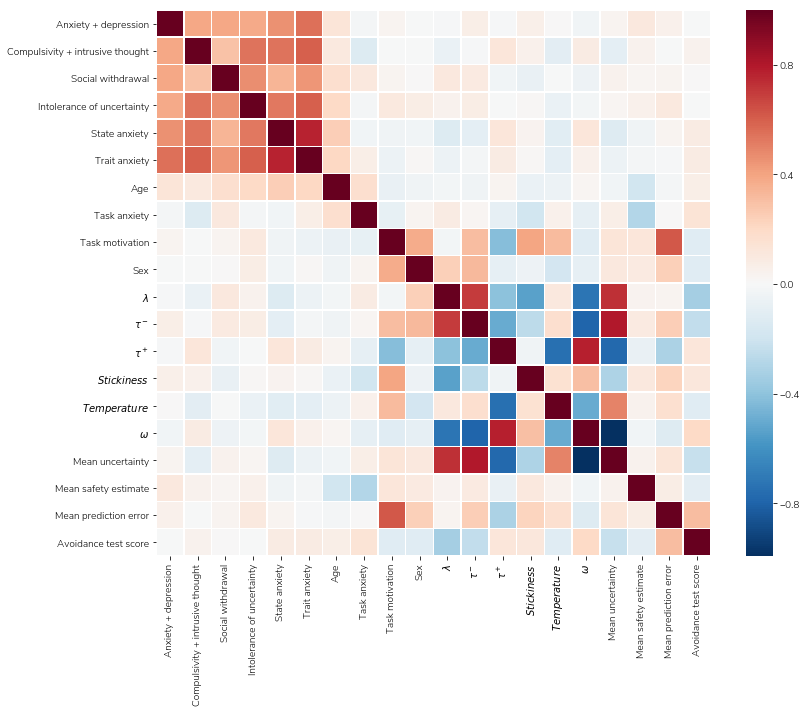

In [14]:
f, ax = plt.subplots(figsize=(12,10), facecolor='white')    
corr = full_df[[i for i in full_df.columns if 'Subject' not in i and 'hpd' not in i and 'sd_' not in i and 'error' not in i and i not in raw_qns.columns]].corr()
columns = ['Anxiety + depression', 'Compulsivity + intrusive thought', 'Social withdrawal', 'Intolerance of uncertainty', 'State anxiety', 
          'Trait anxiety', 'Age', 'Task anxiety', 'Task motivation', 'Sex', r'$\lambda$', r'$\tau^-$', r'$\tau^+$', '$Stickiness$',
          '$Temperature$', '$\omega$', 'Mean uncertainty', 'Mean safety estimate', 'Mean prediction error', 'Avoidance test score']
corr.columns = columns
corr.index = columns
sns.heatmap(corr, cmap='RdBu_r', linewidths=.5, ax=ax)
plt.tight_layout()
plt.savefig('../figures/variable_correlations.svg')

Specify the outcomes and predictors for our linear models

In [15]:
outcomes = ['mean_tau_p', 'mean_tau_n', 'mean_value', 'mean_uncertainty', 'mean_decay', 'mean_temp', 'mean_stickiness', 'ws', 'ls']

predictors = (['STICSA_T', 'age', 'sex', 'mean_health'],
              ['IUS', 'age', 'sex', 'mean_health'],
              ['STICSA_S', 'age', 'sex', 'mean_health'],
              ['AD', 'Compul', 'SW', 'age', 'sex', 'mean_health'])

# Fit the regression models

Models are constructed and fit using [Bambi](https://bambinos.github.io/bambi/). Here we construct the models and save them, before fitting them on a cluster (using the `code/fit_regression_model.py` script) and reloading them. These models don't take too long to fit themselves, but there are quite a few of them and so the fitting time adds up.

In [16]:
models_dict = OrderedDict()
results_dict = OrderedDict()

for n, outcome in enumerate(outcomes):
    
    models_dict[outcome] = []
    results_dict[outcome] = []
    
    for nn in range(len(predictors)):

        model = Model(full_df)
        model.predictors = predictors[nn]
        model.outcome = outcome
        model.name = outcome + '__' + '_'.join(predictors[nn])
        
        with open('../Data/regression_models/models/{0}.pkl'.format(model.name), 'wb') as file:
            dill.dump(model, file)
        

Then we reload the fitted models.

In [17]:
models = []

for m in tqdm([i for i in os.listdir('../Data/regression_models/results')]):
    with open(os.path.join('../Data/regression_models/results', m), 'rb') as f:
        models.append(dill.load(f))

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:53<00:00,  4.14s/it]


## Plot the results

First we need to extract the results of our model fitting, and tidy up the output a little.

In [18]:
# Get results of model fitting
summary_dfs = []
for n, lm in tqdm(enumerate(models)):
    summary = lm[2000:].summary()  # Drop initial 2000 samples
    summary = summary[~summary.index.isin(['Intercept', 'sex', 'mean_health', 'age'])]
    summary = summary[~summary.index.str.contains('_sd')]
    summary['outcome'] = lm.model.outcome
    summary_dfs.append(summary)
df = pd.concat(summary_dfs)

# Get results for modelling variables
factor_df_model = df[(df.index.isin(['AD', 'Compul', 'SW'])) & (~df.outcome.isin(['ws', 'ls']))]
anx_df_model = df[(df.index.isin(['IUS', 'STICSA_T', 'STICSA_S'])) & (~df.outcome.isin(['ws', 'ls']))]

# Get results for pure behavioural measures
factor_df_model_free = df[(df.index.isin(['AD', 'Compul', 'SW'])) & (df.outcome.isin(['ws', 'ls']))]
anx_df_model_free = df[(df.index.isin(['IUS', 'STICSA_T', 'STICSA_S'])) & (df.outcome.isin(['ws', 'ls']))]

# Remove variables we don't care about - we had no hypotheses regarding decay rates, stickiness, or temperature parameters 
# but ran these models in case they are of interest to others
factor_df_model = remove_other_vars(factor_df_model)
anx_df_model = remove_other_vars(anx_df_model)
factor_df_model_free = remove_other_vars(factor_df_model_free)
anx_df_model_free = remove_other_vars(anx_df_model_free)

36it [01:03,  1.25s/it]


Then we relabel variables and generally make the output tables look presentable.

In [19]:
anx_df_model_pretty = make_table_look_nice(anx_df_model)
anx_df_model_pretty

,Target variable,Predictor,Estimate (+/- HPDI)
0,Threat update ($\tau^-$),IUS,"0.07 (-0.03, 0.16)"
1,Threat update ($\tau^-$),STICSA S,"-0.09 (-0.19, 0.01)"
2,Threat update ($\tau^-$),STICSA T,"-0.03 (-0.12, 0.07)"
3,Safety update ($\tau^+$),IUS,"0.0 (-0.1, 0.09)"
4,Safety update ($\tau^+$),STICSA S,"0.12 (0.02, 0.21)"
5,Safety update ($\tau^+$),STICSA T,"0.09 (-0.01, 0.18)"
6,Mean safety uncertainty,IUS,"-0.05 (-0.14, 0.05)"
7,Mean safety uncertainty,STICSA S,"-0.09 (-0.19, 0.01)"
8,Mean safety uncertainty,STICSA T,"-0.08 (-0.18, 0.01)"
9,Mean safety probability,IUS,"-0.02 (-0.12, 0.07)"


In [20]:
factor_df_model_pretty = make_table_look_nice(factor_df_model)
factor_df_model_pretty

,Target variable,Predictor,Estimate (+/- HPDI)
0,Threat update ($\tau^-$),AD,"0.04 (-0.06, 0.15)"
1,Threat update ($\tau^-$),Compul,"-0.06 (-0.17, 0.04)"
2,Threat update ($\tau^-$),SW,"0.08 (-0.02, 0.19)"
3,Safety update ($\tau^+$),AD,"-0.04 (-0.15, 0.07)"
4,Safety update ($\tau^+$),Compul,"0.14 (0.03, 0.25)"
5,Safety update ($\tau^+$),SW,"-0.05 (-0.15, 0.06)"
6,Mean safety uncertainty,AD,"0.05 (-0.06, 0.16)"
7,Mean safety uncertainty,Compul,"-0.1 (-0.21, 0.0)"
8,Mean safety uncertainty,SW,"0.02 (-0.08, 0.13)"
9,Mean safety probability,AD,"-0.06 (-0.17, 0.04)"


And finally create a plot showing the results

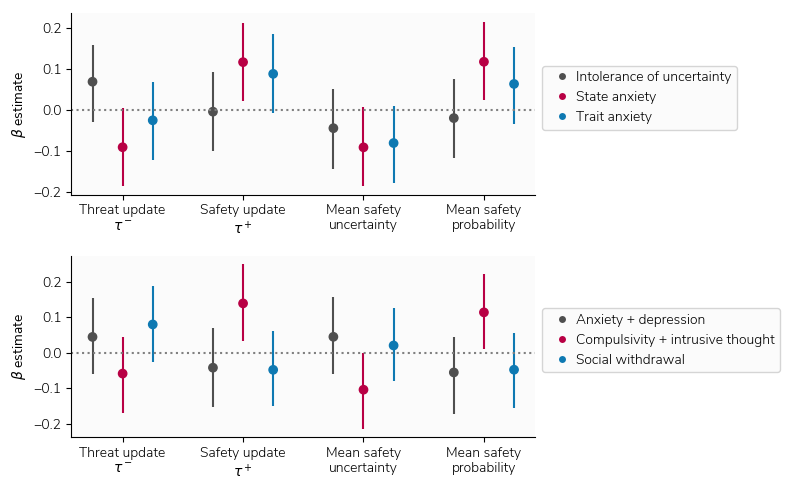

In [21]:
f, ax = plt.subplots(2, 1, figsize=(8, 5), dpi=100, facecolor='white')

# Plot anxiety results
anx_df_model.loc[:, 'predictor'] = anx_df_model.index
anx_df_model['outcome'] = anx_df_model['outcome'].replace(outcomes_dict)
xpos = np.arange(len(anx_df_model)).astype(float)
for i in range(len(anx_df_model['outcome'].unique())):
    xpos[i*3:i*3+3] += i * 1
ax[0].scatter(xpos, 'mean', facecolors=pal[:3], data=anx_df_model, label=None)
ax[0].errorbar(xpos, 'mean', yerr=[anx_df_model['mean'] - anx_df_model['hpd0.95_lower'], 
                                anx_df_model['hpd0.95_upper'] - anx_df_model['mean']], fmt='none', label=None, ecolor=pal[:3], data=anx_df_model)  
ax[0].axhline(0, linestyle=':', c='grey')
ax[0].set_xticks(np.arange(len(anx_df_model['outcome'].unique())) * 4 + 1)
ax[0].set_xticklabels(anx_df_model['outcome'].unique())
ax[0].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Intolerance of uncertainty', markerfacecolor=pal[0], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='State anxiety', markerfacecolor=pal[1], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Trait anxiety', markerfacecolor=pal[2], markersize=5)]
ax[0].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

# Plot factor results
factor_df_model.loc[:, 'predictor'] = factor_df_model.index
factor_df_model['outcome'] = factor_df_model['outcome'].replace(outcomes_dict)
xpos = np.arange(len(factor_df_model)).astype(float)
for i in range(len(factor_df_model['outcome'].unique())):
    xpos[i*3:i*3+3] += i * 1
ax[1].scatter(xpos, 'mean', facecolors=pal[:3], data=factor_df_model, label=None)
ax[1].errorbar(xpos, 'mean', yerr=[factor_df_model['mean'] - factor_df_model['hpd0.95_lower'], 
                                factor_df_model['hpd0.95_upper'] - factor_df_model['mean']], fmt='none', label=None, ecolor=pal[:3], data=factor_df_model)  
ax[1].axhline(0, linestyle=':', c='grey')
ax[1].set_xticks(np.arange(len(factor_df_model['outcome'].unique())) * 4 + 1)
ax[1].set_xticklabels(factor_df_model['outcome'].unique())
ax[1].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Anxiety + depression', markerfacecolor=pal[0], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Compulsivity + intrusive thought', markerfacecolor=pal[1], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Social withdrawal', markerfacecolor=pal[2], markersize=5)]
ax[1].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

sns.despine()
plt.tight_layout()
plt.savefig('../figures/regression_plot.svg')
plt.savefig('../figures/regression_plot.png')

And the same for the model-free measures.

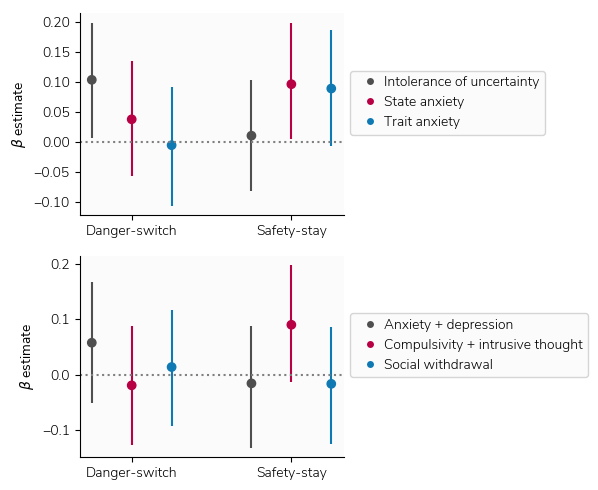

In [22]:
f, ax = plt.subplots(2, 1, figsize=(6, 5), dpi=100, facecolor='white')

# Plot anxiety results
anx_df_model_free.loc[:, 'predictor'] = anx_df_model_free.index
anx_df_model_free['outcome'] = anx_df_model_free['outcome'].replace(outcomes_dict)
xpos = np.arange(len(anx_df_model_free)).astype(float)
for i in range(len(anx_df_model_free['outcome'].unique())):
    xpos[i*3:i*3+3] += i * 1
ax[0].scatter(xpos, 'mean', facecolors=pal[:3], data=anx_df_model_free, label=None)
ax[0].errorbar(xpos, 'mean', yerr=[anx_df_model_free['mean'] - anx_df_model_free['hpd0.95_lower'], 
                                anx_df_model_free['hpd0.95_upper'] - anx_df_model_free['mean']], fmt='none', label=None, ecolor=pal[:3], data=anx_df_model_free)  
ax[0].axhline(0, linestyle=':', c='grey')
ax[0].set_xticks(np.arange(len(anx_df_model_free['outcome'].unique())) * 4 + 1)
ax[0].set_xticklabels(anx_df_model_free['outcome'].unique())
ax[0].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Intolerance of uncertainty', markerfacecolor=pal[0], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='State anxiety', markerfacecolor=pal[1], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Trait anxiety', markerfacecolor=pal[2], markersize=5)]
ax[0].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

# Plot factor results
factor_df_model_free.loc[:, 'predictor'] = factor_df_model_free.index
factor_df_model_free['outcome'] = factor_df_model_free['outcome'].replace(outcomes_dict)
xpos = np.arange(len(factor_df_model_free)).astype(float)
for i in range(len(factor_df_model_free['outcome'].unique())):
    xpos[i*3:i*3+3] += i * 1
ax[1].scatter(xpos, 'mean', facecolors=pal[:3], data=factor_df_model_free, label=None)
ax[1].errorbar(xpos, 'mean', yerr=[factor_df_model_free['mean'] - factor_df_model_free['hpd0.95_lower'], 
                                factor_df_model_free['hpd0.95_upper'] - factor_df_model_free['mean']], fmt='none', label=None, ecolor=pal[:3], data=factor_df_model_free)  
ax[1].axhline(0, linestyle=':', c='grey')
ax[1].set_xticks(np.arange(len(factor_df_model_free['outcome'].unique())) * 4 + 1)
ax[1].set_xticklabels(factor_df_model_free['outcome'].unique())
ax[1].set_ylabel(r"$\beta$ estimate")

legend_elements = [Line2D([0], [0], marker='o', color='None', label='Anxiety + depression', markerfacecolor=pal[0], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Compulsivity + intrusive thought', markerfacecolor=pal[1], markersize=5),
                   Line2D([0], [0], marker='o', color='None', label='Social withdrawal', markerfacecolor=pal[2], markersize=5)]
ax[1].legend(handles=legend_elements, loc='upper left', ncol=1, handletextpad=0.01, mode=None, columnspacing=0.1, 
            bbox_to_anchor=(1, 0.75))

sns.despine()
plt.tight_layout()
plt.savefig('../figures/regression_plot_model_free.svg')
plt.savefig('../figures/regression_plot_model_free.png')

## Sanity check - value and outcome

When I first saw these results, I was a little surprised as they weren't in the direction I'd expected. One obvious explanation for this is that things have got switched round somewhere - perhaps our "value" variable, supposedly representing the probability of safety, is the wrong way round and is in fact lower when things are safe? 

Here we perform a simple check to make sure this isn't the case - value should be higher when outcomes are 1 than when they are 0, as we get more 1 outcomes when the stimulus is safe.

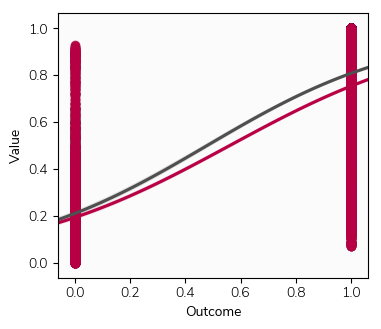

In [23]:
trialwise_df = pd.read_csv('../Data/simulated_data.csv')
trialwise_df.Subject = trialwise_df.Subject.str.replace('data_', '')
trialwise_df = pd.merge(trialwise_df, full_df, on='Subject')
trialwise_df['trial_number'] = np.tile(np.arange(269), len(trialwise_df) / 269)

plt.figure(figsize=(4, 3.5), dpi=100)
sns.regplot(trialwise_df.loc[trialwise_df['o'] >= 0, 'o'][:5000], trialwise_df.loc[trialwise_df['o'] >= 0, 'value_0'][:5000], logistic=True, color=pal[0])
sns.regplot(trialwise_df.loc[trialwise_df['o2'] >= 0, 'o2'][:5000], trialwise_df.loc[trialwise_df['o'] >= 0, 'value_1'][:5000], logistic=True, color=pal[1])
plt.xlabel("Outcome")
plt.ylabel("Value");

This appears to be the correct way round!

## Partial least squares regression

Partial least squares identifies directions in two datasets that maximises covariance between them. Here we use this method to identify components with high covariance between questionnaires and model parameters/quantities (e.g. update rates, average uncertainty). We exclude the STICSA state subscale here as we want to focus on trait variables.

This is done using cross-validation on 75% of the data - the remaining 25% is held out for evaluation of the final model. 

In [24]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV   

# Create PLS
pls = PLSRegression(n_components=5)

# Get data
X = full_df[[i for i in full_df.columns if '.' in i 
             and not 'hpd' in i and not 'sticsa_s' in i]]
y = full_df[['mean_decay', 'mean_tau_p', 'mean_tau_n', 'mean_omega', 'mean_stickiness', 'mean_temp',
           'mean_value', 'mean_uncertainty']].copy()

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)
 

### Select number of components

We first use cross-validatated grid search to select the optimal number of components, with each number evaluated based on its predictive accuracy using average mean squared error (MSE) across five folds of cross validation. 

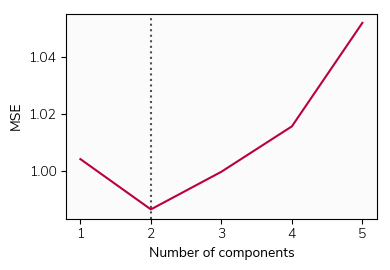

In [25]:
grid_search = GridSearchCV(pls, param_grid={'n_components': range(1, 6)}, cv=10, iid=False, 
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

plt.figure(figsize=(4, 2.8), dpi=100)
plt.plot(range(1, 6), np.abs(grid_search.cv_results_['mean_test_score']), color=pal[1])
plt.xlabel("Number of components")
plt.axvline(2, linestyle=':', color=pal[0])
plt.ylabel("MSE");
plt.tight_layout()
plt.savefig('../figures/pls_n_components.svg')

### Check performance on held out data

This is the important test - this model was trained on 75% of our data and has never seen the remaing 25%. If it's a good model, when we feed it the values of our questionnaire measures from the testing data (the held out 25%) it should predict the associated parameter values accurately.

In [26]:
# Prediction
Y_pred = grid_search.best_estimator_.predict(X_test)
 
# Calculate scores
score = r2_score(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)

print("R^2 score = {0}\nMSE = {1}".format(score, mse))

R^2 score = 0.0205146171747
MSE = 0.954790478962


While this isn't amazing, it's not terrible either. We can look at how well it's predicting different parameters in the model.

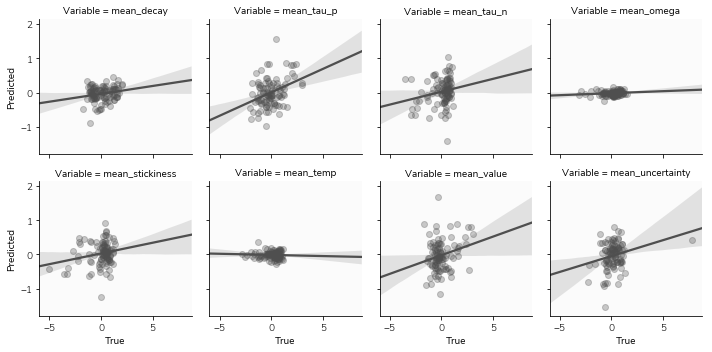

In [27]:
y_pred_df = pd.DataFrame({'Predicted':Y_pred.flatten(), 'True':y_test.values.flatten(), 'Variable': np.tile(y_test.columns, 100)})
sns.lmplot(x='True', y='Predicted', col='Variable', hue='Variable', data=y_pred_df, col_wrap=4, size=2.5, 
           scatter_kws={'alpha': 0.3}, palette=[pal[0]]);

This seems to do a decent job on most of the variables, although it fails pretty badly on the temperature and unchosen option weighting parameters, suggesting they're probably not meaningfully related to the questionnaire measures.

### Permutation testing

To provide additional confidence that these components are meaningful, we can use permutation testing to asses how often we find predictive accuracy this strong or better under the null hypothesis. To do this we refit our PLS regression using permuted y labels (model parameters) for the training data, and then assess its predictive accuracy in the test set. This is repeated 1000 times to build a distribution of mean sqaured error values under the null hypothesis.

In [28]:
import copy
permutation_pls = copy.deepcopy(grid_search.best_estimator_)

n_perm = 1000
permutation_mse = np.zeros(n_perm)

for i in tqdm(range(n_perm)):
    permuted_y = y.copy()
    permuted_y = permuted_y.sample(frac=1)
    permutation_pls.fit(X, permuted_y)
    y_pred = permutation_pls.predict(X_test)
    permutation_mse[i] = mean_squared_error(y_test, y_pred) 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.19it/s]


We can take the number of times we found a result this low or lower to get a P value for our true MSE value

In [29]:
"P value = {0}".format((permutation_mse <= mse).sum() / float(n_perm))

'P value = 0.025'

And plotting our true effect against this null distribution gives an idea of what this looks like

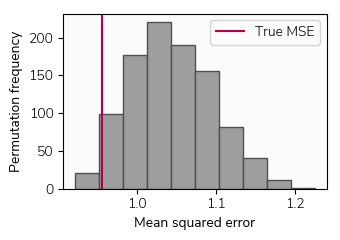

In [30]:
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.hist(permutation_mse, ec=pal[0], color=light_pal[0])
plt.axvline(mse, color=pal[1], label='True MSE')
plt.legend()
plt.xlabel("Mean squared error")
plt.ylabel("Permutation frequency")
plt.tight_layout()
plt.savefig("../figures/pls_permutation_test.svg")

### Look at loadings for the modelling variables

Obviously, we want to be able to interpret this model. We can start to do this by looking at the loadings of different variables on our two factors. 

Firstly, we'll look at how the modelling-related variables load.

In [31]:
pls_y_df = pd.DataFrame(dict(variable=y_test.columns.repeat(2), Loading=grid_search.best_estimator_.y_loadings_.flatten(),
                            Component=np.tile([0, 1], y_test.shape[1])))

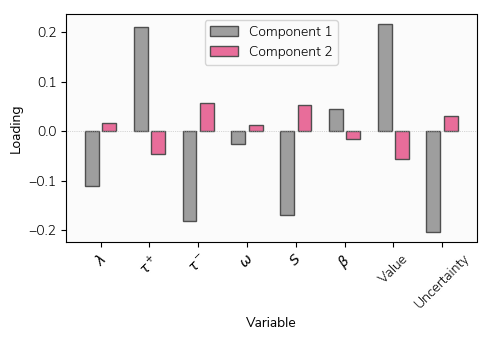

In [32]:
def add_space(positions, spacing=1, increase=0.8):
    spacing_array = np.zeros_like(positions).astype(float)
    for i in np.arange(0, len(spacing_array), spacing):
        spacing_array[int(i):] += increase
    return positions + spacing_array

nice_names = {'mean_decay': r'$\lambda$', 'mean_tau_p': r'$\tau^+$', 'mean_tau_n': r'$\tau^-$', 'mean_omega': r'$\omega$', 'mean_stickiness': '$S$', 'mean_temp': r'$\beta$', 'mean_value': 'Value', 'mean_uncertainty': 'Uncertainty'}
    
plt.figure(figsize=(5, 3.5), dpi=100)
plt.axhline(0, color='#b2b2b2', linestyle=':', linewidth=0.5)
plt.bar(add_space(np.arange(0, 16, 2)), pls_y_df[pls_y_df['Component'] == 0]['Loading'], ec=pal[0], color=light_pal[0], label='Component 1')
plt.bar(add_space(np.arange(1, 16, 2)), pls_y_df[pls_y_df['Component'] == 1]['Loading'], ec=pal[0], color=light_pal[1], label='Component 2')
plt.legend()
plt.xlabel("Variable")
plt.ylabel("Loading")
plt.xticks(add_space(np.arange(0.5, 16.5, 2)), [nice_names[i] for i in y_test.columns], rotation=45);
plt.tight_layout()
plt.savefig('../figures/pls_modelling_loadings.svg')

We have two components, which seem to represent something like this:

**Component 1** - Faster learning from safety, less choice stickiness, higher safety estimates, less uncertainty

**Component 2** - Faster learning from threat, more choice stickiness, lower safety estimates, more uncertainty

### Question loadings

Next we'll look at the loading of the questionnaire measures - of which there are quite a few!

In [33]:
pls_x_df = pd.DataFrame(dict(Loading=grid_search.best_estimator_.x_loadings_.flatten(), Component=np.tile(np.arange(2), len(X.columns)), 
                         variable=np.array(X.columns).repeat(2)))

We need to get the actual questions used for labelling

In [34]:
with open('../html/questionnaires_json.txt', 'r') as f:
    qns_info = json.load(f)
    
new_qns_dict = dict()

for m in qns_info.keys():
    for d in qns_info[m]['questions']:
        new_qns_dict[d['question_id']] = dict(prompt=d['prompt'], questionnaire=m)
pls_x_df['question'] = [re.search('[A-Za-z].+', new_qns_dict[q]['prompt']).group() for q in pls_x_df['variable']]

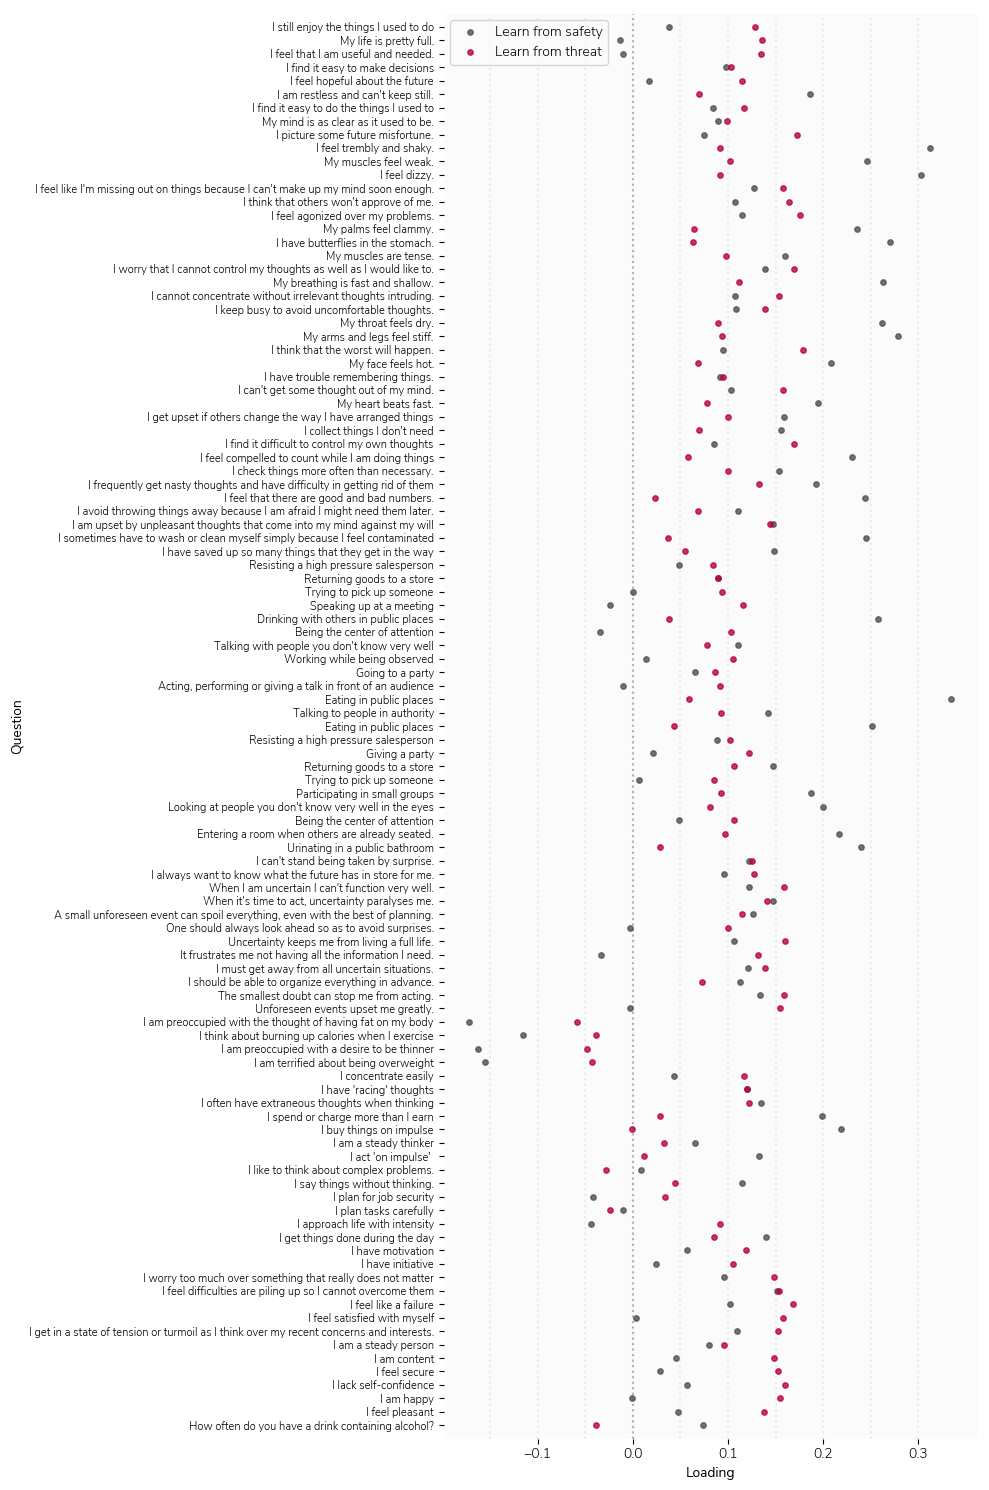

In [35]:
plt.figure(dpi=100, figsize=(10, 15))
for i in np.arange(-0.15, 0.31, 0.05):
    plt.axvline(i, color='#eaeaea', linestyle=':')
plt.axvline(0, color='#b2b2b2', linestyle=':')
component_labels = ['Learn from safety', 'Learn from threat']
for c in [0, 1]:
    plt.scatter(pls_x_df[pls_x_df['Component'] == c]['Loading'], pls_x_df[pls_x_df['Component'] == c]['variable'], 
                color=pal[c], zorder=100, alpha=0.8, s=15, label='{0}'.format(component_labels[c]))
# sns.stripplot(x='Loading', y='variable', hue='Component', data=pls_x_df, palette=pal, alpha=0.8)
plt.yticks(range(len(pls_x_df[pls_x_df['Component'] == c])), pls_x_df[pls_x_df['Component'] == c]['question'], fontsize=8)
sns.despine(left=True, bottom=True)
plt.ylim(-1, len(pls_x_df['variable'].unique()))
plt.legend(loc='upper left')
plt.xlabel("Loading")
plt.ylabel("Question")
plt.tight_layout()
plt.savefig('../figures/pls_question_loadings.pdf')
plt.savefig('../figures/pls_question_loadings.svg')

### Find items that differentiate the two components

For the sake of illustration, it's useful to identify some items showing strong differences in loadings between the factors. This gives us an idea of the kind of items that load on to each component.

In [36]:
high_diff = np.percentile(pls_x_df[pls_x_df['Component'] == 0]['Loading'].values - pls_x_df[pls_x_df['Component'] == 1]['Loading'].values, 90)#
low_diff = np.percentile(pls_x_df[pls_x_df['Component'] == 0]['Loading'].values - pls_x_df[pls_x_df['Component'] == 1]['Loading'].values, 10)

In [37]:
dfs = []

for i in pls_x_df['variable'].unique():
    diff = pls_x_df[(pls_x_df['variable'] == i) & (pls_x_df['Component'] == 0)]['Loading'].values - pls_x_df[(pls_x_df['variable'] == i) & (pls_x_df['Component'] == 1)]['Loading'].values
    if diff <= low_diff or diff >= high_diff:
        dfs.append(pls_x_df[(pls_x_df['variable'] == i)])
#     if (pls_x_df[(pls_x_df['variable'] == i) & (pls_x_df['Component'] == 0)]['Loading'] > np.percentile(pls_x_df[pls_x_df['Component'] == 0]['Loading'], 80)).values[0] or \
#         (pls_x_df[(pls_x_df['variable'] == i) & (pls_x_df['Component'] == 1)]['Loading'] > np.percentile(pls_x_df[pls_x_df['Component'] == 1]['Loading'], 80)).values[0]:
#         dfs.append(pls_x_df[(pls_x_df['variable'] == i)])
        
pls_x_df_top = pd.concat(dfs).reset_index()

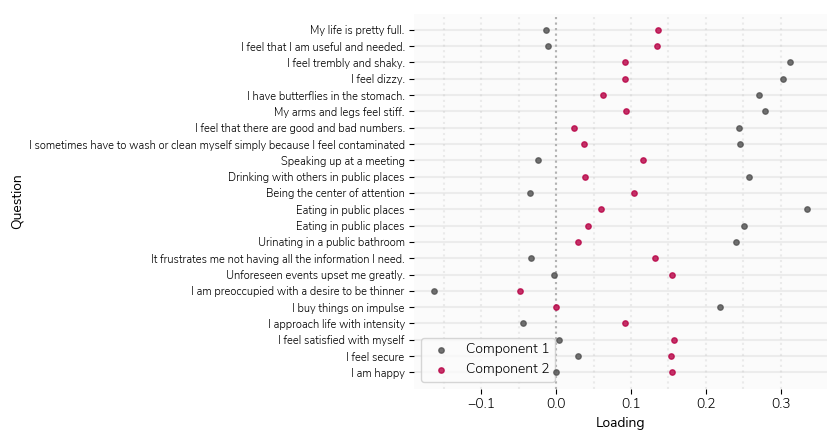

In [39]:
plt.figure(dpi=100, figsize=(8.5, 4.5))
for i in np.arange(-0.15, 0.31, 0.05):
    plt.axvline(i, color='#eaeaea', linestyle=':')
plt.axvline(0, color='#b2b2b2', linestyle=':')
component_labels = ['Component 1', 'Component 2']
for i in range(len(pls_x_df_top[pls_x_df_top['Component'] == c])):
    plt.axhline(i, color='#b2b2b2', alpha=0.2)
for c in [0, 1]:
    plt.scatter(pls_x_df_top[pls_x_df_top['Component'] == c]['Loading'], pls_x_df_top[pls_x_df_top['Component'] == c]['variable'], 
                color=pal[c], zorder=100, alpha=0.8, s=15, label='{0}'.format(component_labels[c]))
plt.yticks(range(len(pls_x_df_top[pls_x_df_top['Component'] == c])), pls_x_df_top[pls_x_df_top['Component'] == c]['question'].values, fontsize=8)
sns.despine(left=True, bottom=True)
plt.ylim(-1, len(pls_x_df_top['variable'].unique()))
plt.legend(loc='lower left')
plt.xlabel("Loading")
plt.ylabel("Question")
plt.tight_layout()
plt.savefig("../figures/top_difference_loadings.svg")